# Answering Business Questions using SQL

In this project, we're going to answer business questions by 
- Writng SQL queries to extract the relevant data
- Create plots where necessary to visualize the data


In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

# Function that takes a SQL query as an argument and returns a pandas dataframe of that query.
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query,conn)

# Function that takes a SQL command as an argument and executes it using the sqlite module.    
def run_command(cmd):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(cmd)

# Function that calls the run_query() function to return a list of all tables and views in the database.
def show_tables():
    detail_query = '''SELECT name, type 
    FROM sqlite_master 
    WHERE type IN ("table","view");'''

    return run_query(detail_query)
        
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


### Finding Out The Most Selling Genre In USA

In [2]:
genre_usa ='''
with genre_usa AS
    (
     SELECT IL.*
     FROM invoice_line IL
     INNER JOIN invoice I ON I.invoice_id = IL.invoice_id
     INNER JOIN customer C ON C.customer_id = I.customer_id
     WHERE C.country = "USA"
    )
SELECT G.name as genre_name,
COUNT(GU.track_id) as number_of_tracks_sold,
CAST(COUNT(GU.track_id) AS Float)/(SELECT COUNT(*) FROM genre_usa) as percentage_of_total
FROM genre_usa GU
INNER JOIN track T ON T.track_id = GU.track_id
INNER JOIN genre G ON G.genre_id = T.genre_id
GROUP BY G.genre_id
ORDER BY 2 DESC
'''

run_query(genre_usa)




,genre_name,number_of_tracks_sold,percentage_of_total
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


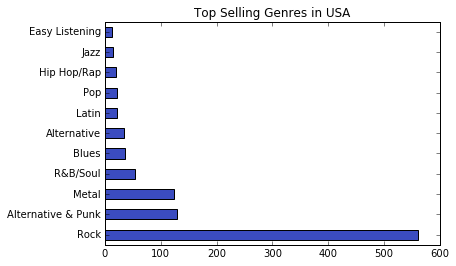

In [3]:
genre_table = run_query(genre_usa)
genre_table.set_index('genre_name', inplace=True)

# Keeping genres where sales are greater than 10 tracks
genre_table = genre_table[genre_table['number_of_tracks_sold']>10]

# Plotting horizontal bar graph
genre_table['number_of_tracks_sold'].plot.barh(
    title = 'Top Selling Genres in USA',
    xlim = (0,600),
    colormap = plt.cm.coolwarm)
plt.ylabel(' ')


With the above observation of the genres and their sales in the USA, we should be marketting the folllowing albums for higher sales - 
- Red Tone (Genre- Punk)
- Slim Jim Bites (Genre - Blues)

In [4]:
query = '''Select * from employee LIMIT 10'''
run_query(query)

,employee_id,last_name,first_name,title,reports_to,birthdate,hire_date,address,city,state,country,postal_code,phone,fax,email
0,1,Adams,Andrew,General Manager,NaN,1962-02-18 00:00:00,2016-08-14 00:00:00,11120 Jasper Ave NW,Edmonton,AB,Canada,T5K 2N1,+1 (780) 428-9482,+1 (780) 428-3457,andrew@chinookcorp.com
1,2,Edwards,Nancy,Sales Manager,1.0,1958-12-08 00:00:00,2016-05-01 00:00:00,825 8 Ave SW,Calgary,AB,Canada,T2P 2T3,+1 (403) 262-3443,+1 (403) 262-3322,nancy@chinookcorp.com
2,3,Peacock,Jane,Sales Support Agent,2.0,1973-08-29 00:00:00,2017-04-01 00:00:00,1111 6 Ave SW,Calgary,AB,Canada,T2P 5M5,+1 (403) 262-3443,+1 (403) 262-6712,jane@chinookcorp.com
3,4,Park,Margaret,Sales Support Agent,2.0,1947-09-19 00:00:00,2017-05-03 00:00:00,683 10 Street SW,Calgary,AB,Canada,T2P 5G3,+1 (403) 263-4423,+1 (403) 263-4289,margaret@chinookcorp.com
4,5,Johnson,Steve,Sales Support Agent,2.0,1965-03-03 00:00:00,2017-10-17 00:00:00,7727B 41 Ave,Calgary,AB,Canada,T3B 1Y7,1 (780) 836-9987,1 (780) 836-9543,steve@chinookcorp.com
5,6,Mitchell,Michael,IT Manager,1.0,1973-07-01 00:00:00,2016-10-17 00:00:00,5827 Bowness Road NW,Calgary,AB,Canada,T3B 0C5,+1 (403) 246-9887,+1 (403) 246-9899,michael@chinookcorp.com
6,7,King,Robert,IT Staff,6.0,1970-05-29 00:00:00,2017-01-02 00:00:00,590 Columbia Boulevard West,Lethbridge,AB,Canada,T1K 5N8,+1 (403) 456-9986,+1 (403) 456-8485,robert@chinookcorp.com
7,8,Callahan,Laura,IT Staff,6.0,1968-01-09 00:00:00,2017-03-04 00:00:00,923 7 ST NW,Lethbridge,AB,Canada,T1H 1Y8,+1 (403) 467-3351,+1 (403) 467-8772,laura@chinookcorp.com


In [5]:
sales_rep = '''SELECT
    E.first_name ||' '||E.last_name as employee_name,
    COUNT(I.invoice_id) as number_of_sales,
    SUM(I.total) as total_dollar_amt,
    E.hire_date,
    E.title as employee_title
    FROM customer C
    INNER JOIN employee E ON E.employee_id = C.support_rep_id
    INNER JOIN invoice I ON I.customer_id = C.customer_id
    GROUP BY E.employee_id
    ORDER BY E.employee_id'''

run_query(sales_rep)

,employee_name,number_of_sales,total_dollar_amt,hire_date,employee_title
0,Jane Peacock,212,1731.51,2017-04-01 00:00:00,Sales Support Agent
1,Margaret Park,214,1584.00,2017-05-03 00:00:00,Sales Support Agent
2,Steve Johnson,188,1393.92,2017-10-17 00:00:00,Sales Support Agent


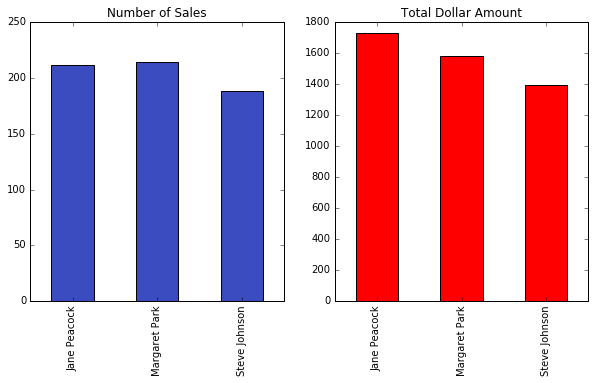

In [6]:
# Plotting total number of saleas and total dollar amount for the employee
sales = run_query(sales_rep)
sales.set_index('employee_name', inplace = True, drop = True)

fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
sales['number_of_sales'].plot.bar(title = 'Number of Sales',colormap = plt.cm.coolwarm, ax = ax1)
sales['total_dollar_amt'].plot.bar(title = 'Total Dollar Amount', colormap = plt.cm.autumn, ax = ax2)

plt.ylabel(' ')
ax1.set(xlabel = '')
ax2.set(xlabel = '')


- Jane Peacock has highest dollar amount from the sales.
- Margaret Park has higher number of sales than Jane Peacock but the total dollar amount generated from her sales are lower than Jane Peacock.
- Margaret should strategize to prmote and sell higher dollar value products. 
- Steve Johnson has the lowest number of sales and total dollar amount. But, Steve has less experience within the organization as he was hired later than the other employees. Steve should continue to work on the sales and revisit the stats after a few months for feedback.


### Analyze Sales Data For Customers From Each Different Country

In [7]:
country_query = '''
with country_data AS
    (
     SELECT
        c.customer_id as customer_id,
        CASE 
            WHEN (SELECT COUNT(*) FROM customer GROUP BY country HAVING country = c.country) = 1 THEN "Other"
            ELSE c.country 
        END as country_name,
        I.total as total,
        I.invoice_id as invoice_id
     FROM
     customer C
     INNER JOIN invoice I ON C.customer_id = I.customer_id
    )
    
SELECT 
    country_name,
    number_of_customers,
    total_value_of_sales,
    avg_sales_per_customer,
    avg_order_value
FROM 
    (
     SELECT 
        country_name,
        COUNT(DISTINCT customer_id) as number_of_customers, 
        SUM(total) as total_value_of_sales,
        COUNT(invoice_id) as number_of_orders,
        CAST(SUM(total) as Float)/CAST(COUNT(DISTINCT customer_id) as Float) as avg_sales_per_customer,
        CAST(SUM(total) as Float)/CAST(COUNT(DISTINCT invoice_id) as Float) as avg_order_value,
        CASE 
            WHEN country_name = 'Other' THEN 1
            ELSE 0
        END as sort_value
     FROM
     country_data
     GROUP BY country_name
    )
ORDER BY sort_value ASC, total_value_of_sales DESC'''

country_data = run_query(country_query)
country_data

,country_name,number_of_customers,total_value_of_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


# Visualizing Sales Data

In [8]:
# Copying country sales data to a seperate dataframe and modifying the index
country_sales_data = country_data
country_sales_data.set_index('country_name', inplace = True, drop = True)

In [9]:
country_sales_data.head()

,number_of_customers,total_value_of_sales,avg_sales_per_customer,avg_order_value
country_name,,,,
USA,13,1040.49,80.037692,7.942672
Canada,8,535.59,66.948750,7.047237
Brazil,5,427.68,85.536000,7.011148
France,5,389.07,77.814000,7.781400
Germany,4,334.62,83.655000,8.161463


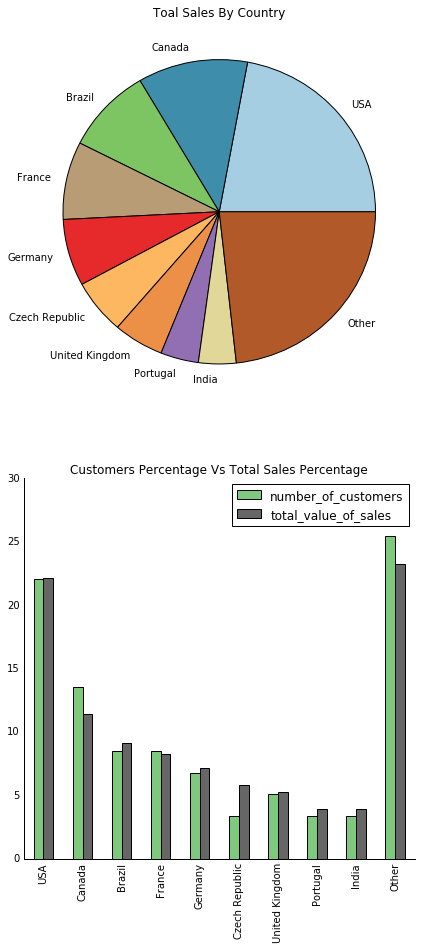

In [18]:
fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (10,10))

# Axis 1 - Pie chart for Country Sales
country_sales_data.plot.pie(y = 'total_value_of_sales',title = 'Toal Sales By Country', legend = False, figsize = (7,15),fontsize = 10,shadow = False,colormap=plt.cm.Paired,ax=ax1)
ax1.set_ylabel('')

# Axis 2 - Customers Percentage Vs Total Sales Percentage
cols = ['number_of_customers','total_value_of_sales']
sales_cust = country_sales_data[cols].copy()
sales_cust.index.name = ''
for c in cols:
    sales_cust[c] = sales_cust[c]/(sales_cust[c].sum()/100)

sales_cust.plot.bar(title = 'Customers Percentage Vs Total Sales Percentage', colormap = plt.cm.Accent, ax = ax2)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines['top'].set_visible(False)
ax2.spines["right"].set_visible(False)

- USA and Canada contirbutes towards the most sales. 
- Czech Republic has lower percentage of customers but a higher sales value. Better marketing campaigns here can boost the sales and the customer base.  
- Similar patetrns can be seen in countries like India and Portugal. Currently, the customer base is small. There is a potential for growth in these countries. Marketing teams should work towards promoting the products for increasing the customer count and sales.

### Analyzing Full Album Vs Individual Track Purchase

In [28]:
# Query that categorizes each invoice as either an album purchase or not
album = '''
with album_track AS
    (
     SELECT 
         A.album_id as album_id,
         T.track_id as track_id
     FROM
         album A
    INNER JOIN track T ON T.album_id = A.album_id
    ORDER BY A.album_id
    ), 
    album_invoice AS 
    (
     SELECT 
        I.invoice_id as invoice_id,
        IL.invoice_line_id as invoice_line_id,
        T.track_id as track_id,
        A.album_id as album_id
     FROM 
        album A
     INNER JOIN track T ON A.album_id = T.album_id 
     INNER JOIN invoice_line IL ON IL.track_id = T.track_id
     INNER JOIN invoice I ON I.invoice_id = IL.invoice_id   
     )
     
SELECT 
    album_sales.full_album_purchase as Full_Album_Purchase,
    COUNT(album_sales.invoice_id) as Number_Of_Invoices,
    CAST(COUNT(album_sales.invoice_id) as Float)/(SELECT COUNT(*) FROM Invoice) as Percentage_Of_Invoices
FROM(
SELECT
    invoice_id as invoice_id,
    CASE
        WHEN (SELECT track_id FROM album_track WHERE album_id=  AI.album_id
                EXCEPT SELECT track_id FROM album_invoice WHERE invoice_id = AI.invoice_id) IS NULL 
            AND (SELECT track_id FROM album_invoice WHERE invoice_id = AI.invoice_id
                EXCEPT SELECT track_id FROM album_track WHERE album_id=  AI.album_id) IS NULL
        THEN 'Yes'
        ELSE 'No'
    END AS full_album_purchase
FROM
album_invoice AI
GROUP BY invoice_id
) album_sales 
GROUP BY album_sales.full_album_purchase
'''

full_album_sales = run_query(album)
full_album_sales


,Full_Album_Purchase,Number_Of_Invoices,Percentage_Of_Invoices
0,No,500,0.814332
1,Yes,114,0.185668


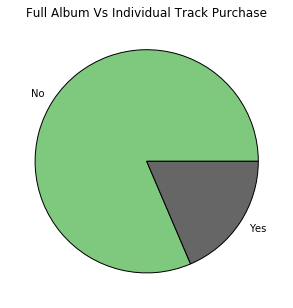

In [29]:
# Plotting Full Album Vs Individual Track Purchase
album_sales = full_album_sales
album_sales.set_index('Full_Album_Purchase',inplace = True,drop = True)
album_sales_plot = album_sales.plot.pie(y = 'Number_Of_Invoices', title = 'Full Album Vs Individual Track Purchase', legend = False, figsize = (5,5),fontsize = 10, colormap = plt.cm.Accent)
album_sales_plot.set_ylabel('')

- More than 80% of the invoices are not a full album purchase. The company should strategize to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album. 

- There are considerable number of whole album purchase as well. Further analysis should be done to identify the paramrters like the artist popularity, genre, etc.. for the whole album purchases.

### Analyzing Which Artist Is Used In The Most Playlists

In [30]:
playlist = '''
WITH playlist_info as
(
SELECT 
    p.playlist_id,
    pt.track_id,
    t.*
FROM playlist p
INNER JOIN playlist_track pt ON p.playlist_id = pt.playlist_id
INNER JOIN track t ON t.track_id = pt.track_id
)

SELECT 
    a.name as Artist_Name,
    COUNT(pi.playlist_id) as Count_Playlist
FROM artist a
INNER JOIN album al ON a.artist_id = al.artist_id
INNER JOIN playlist_info pi ON al.album_id = pi.album_id
GROUP BY a.artist_id
HAVING COUNT(pi.playlist_id)>85
ORDER BY COUNT(pi.playlist_id) DESC
'''
run_query(playlist)

,Artist_Name,Count_Playlist
0,Iron Maiden,516
1,U2,333
2,Metallica,296
3,Led Zeppelin,252
4,Deep Purple,226
5,Lost,184
6,Pearl Jam,177
7,Eric Clapton,145
8,Faith No More,145
9,Lenny Kravitz,143


Many Rock artists are present in most of the palylists which also makes clear that Rock is the most famous and listened to genre. Fu